In [2]:
FN0 = 'tokens'

In [3]:
FN = 'vocabulary-embedding'

In [74]:
seed=42
vocab_size = 200000
embedding_dim = 100
lower = False # dont lower case the text

## Read headlines and descriptions

In [27]:
import pickle as pickle
with open('data/%s.pkl'%FN0, 'rb') as fp:
    heads, desc, keywords = pickle.load(fp)

In [28]:
if lower:
    heads = [h.lower() for h in heads]
    desc = [d.lower() for d in desc]

In [29]:
i=0
heads[i]

'worcester breakfast club for veterans gives hunger its marching orders'

In [30]:
desc[i]

'veterans saluted worcester first ever breakfast club for ex-soldiers which won over hearts minds and bellies the worcester breakfast club for forces veterans met the postal order foregate street saturday the club designed allow veterans place meet socialise eat and drink giving hunger and loneliness their marching orders father-of-two dave carney aged merrimans hill worcester set the club after being inspired other similar clubs across the country said you can see from the picture had good response five out the that attended said they saw the article the newspaper and turned even had old chap travel from droitwich and was late parade three hours generated lot interest and estimate from other veterans who saw the article that next month meeting will attract about people onwards and upwards said the management the pub had been extremely hospitable them carney said they bent over backwards for they really looked after well that the best choice venue could have made they even put for the 

In [31]:
len(heads), len(set(heads))

(1000000, 781441)

In [49]:
len(desc), len(set(desc))

(1000000, 869272)

## Build Vocabulary

In [52]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return list(vocab), vocabcount

In [53]:
vocab, vocabcount = get_vocab(heads+desc)

In [54]:
len(vocab)

2002345

Most popular tokens

In [56]:
print(vocab[:50])
print('...', len(vocab))

['the', 'and', 'for', 'that', 'with', 'was', 'are', 'this', 'from', 'you', 'have', 'has', 'will', 'said', 'not', 'but', 'his', 'they', 'more', 'their', 'new', 'about', 'can', 'all', 'who', 'one', 'which', 'its', 'our', 'been', 'also', 'your', 'had', 'were', 'out', 'when', 'there', 'after', 'first', 'what', 'her', 'time', 'she', 'other', 'would', 'people', 'over', 'than', 'year', 'company']
... 2002345


/Users/krotovd/anaconda/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


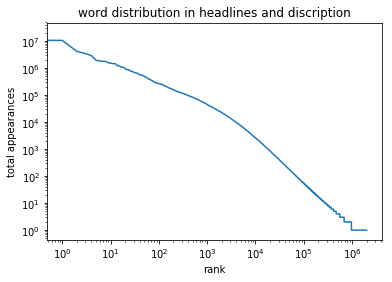

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

## Index words

In [59]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [62]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [63]:
word2idx, idx2word = get_idx(vocab, vocabcount)

## Word Embedding

### Setup GloVe

In [64]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    !unzip {datadir}/{path}

In [65]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [68]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [69]:
glove_embedding_weights.std()

0.040815727600190289

In [71]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## Embedding Matrix

Use GloVe to init embedding matrix

In [75]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514 std 0.0408101295686
number of tokens, in small vocab, found in glove and copied to embedding 138420 0.6921


In [76]:
glove_thr = 0.5

In [77]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix. Use cos distance of GloVe vectors.
Allow for the last nb_unknown_words words inside the embedding matrix to be considered to be outside. Dont accept distances below glove_thr

In [79]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 126962


manually check that the worst substitutions we are going to do are good enough

In [80]:
for orig, sub, score in glove_match[-10:]:
    print (score, orig,'=>', idx2word[sub])

0.500165694462 urethral => prolapse
0.500146832506 shammai => hillel
0.500140830028 qurans => chalkboards
0.500118395348 checkerspot => cambell
0.500089813474 brehon => mahasiddha
0.500049181031 schreier => sobol
0.50004814952 awaaz => paanch
0.500043160099 ottaway => gaer
0.500029984594 tunggal => perkasa
0.500023441819 akef => hawas


In [81]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

## Data

In [82]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

1000000

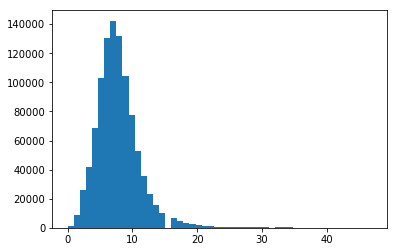

In [84]:
plt.hist(list(map(len,Y)),bins=50);

In [85]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

1000000

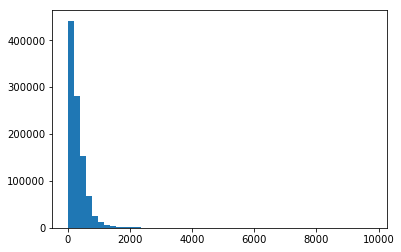

In [86]:
plt.hist(list(map(len,X)),bins=50);

In [87]:
import pickle as pickle
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [88]:
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)